Performance Noise Statistics:
count    500.000000
mean       0.005998
std        0.101659
min       -0.292135
25%       -0.065274
50%        0.004220
75%        0.071082
max        0.319311
Name: performance_noise, dtype: float64

Performance Noise Range: -0.2921 to 0.3193

Dataset Overview:
    intern_id  task_completion_time  feedback_rating  attendance_rate  \
0  INTERN_001              6.996321         3.792647         0.674053   
1  INTERN_002             11.605714         3.144385         0.816760   
2  INTERN_003              9.855952         2.238110         0.949178   
3  INTERN_004              8.789268         4.255180         0.892890   
4  INTERN_005              5.248149         3.738925         0.922624   

   performance_noise  performance_score  
0          -0.249941           5.847073  
1           0.229094           3.024038  
2          -0.138957           2.605961  
3          -0.164540           5.338500  
4           0.102257           8.189948  

Dataset Shape: 

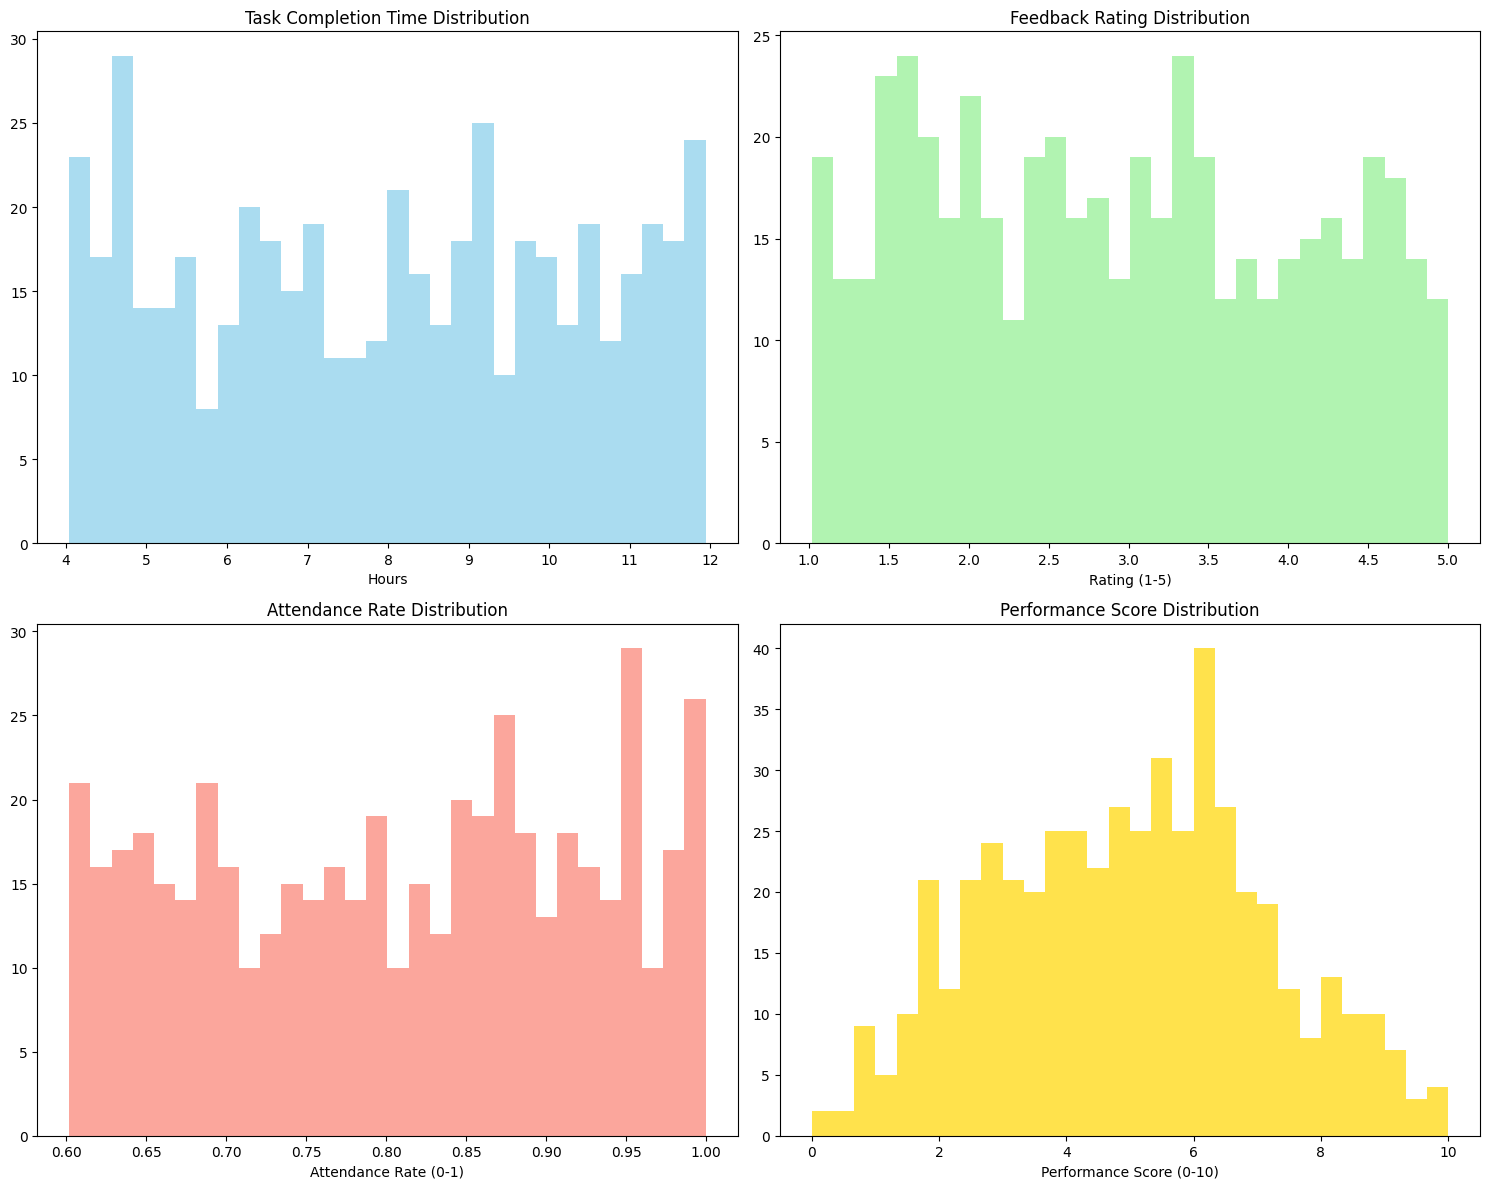

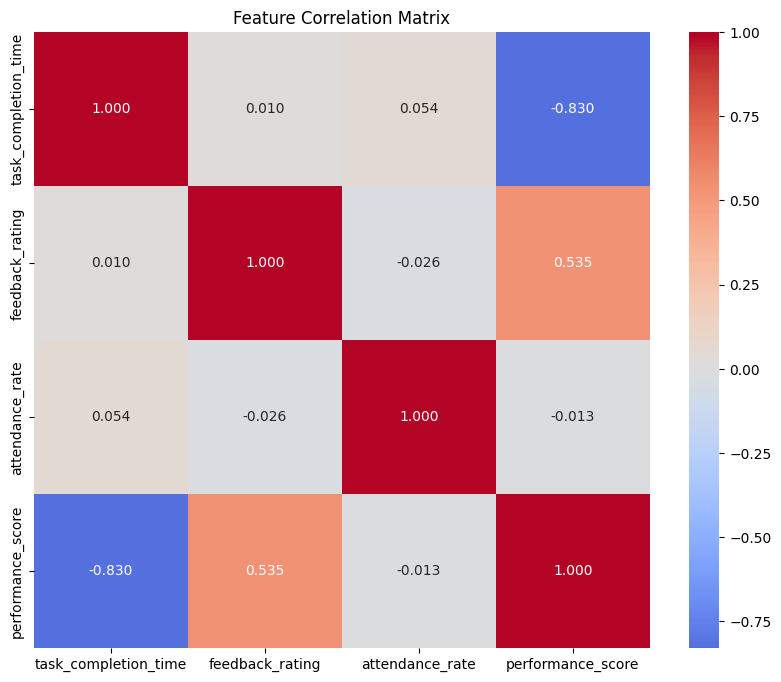


Training set size: 400
Test set size: 100

RANDOM FOREST MODEL
Training MSE: 0.0155
Test MSE: 0.1536
Training MAE: 0.0978
Test MAE: 0.3123
Training R²: 0.9966
Test R²: 0.9648

Feature Importance (Random Forest):
                feature  importance
0  task_completion_time    0.698401
1       feedback_rating    0.294294
2       attendance_rate    0.007305

XGBOOST MODEL
Training MSE: 0.0024
Test MSE: 0.1488
Training MAE: 0.0355
Test MAE: 0.3113
Training R²: 0.9995
Test R²: 0.9659

MODEL COMPARISON
           Model  Test MSE  Test MAE   Test R²
0  Random Forest  0.153625  0.312336  0.964782
1        XGBoost  0.148755  0.311260  0.965898


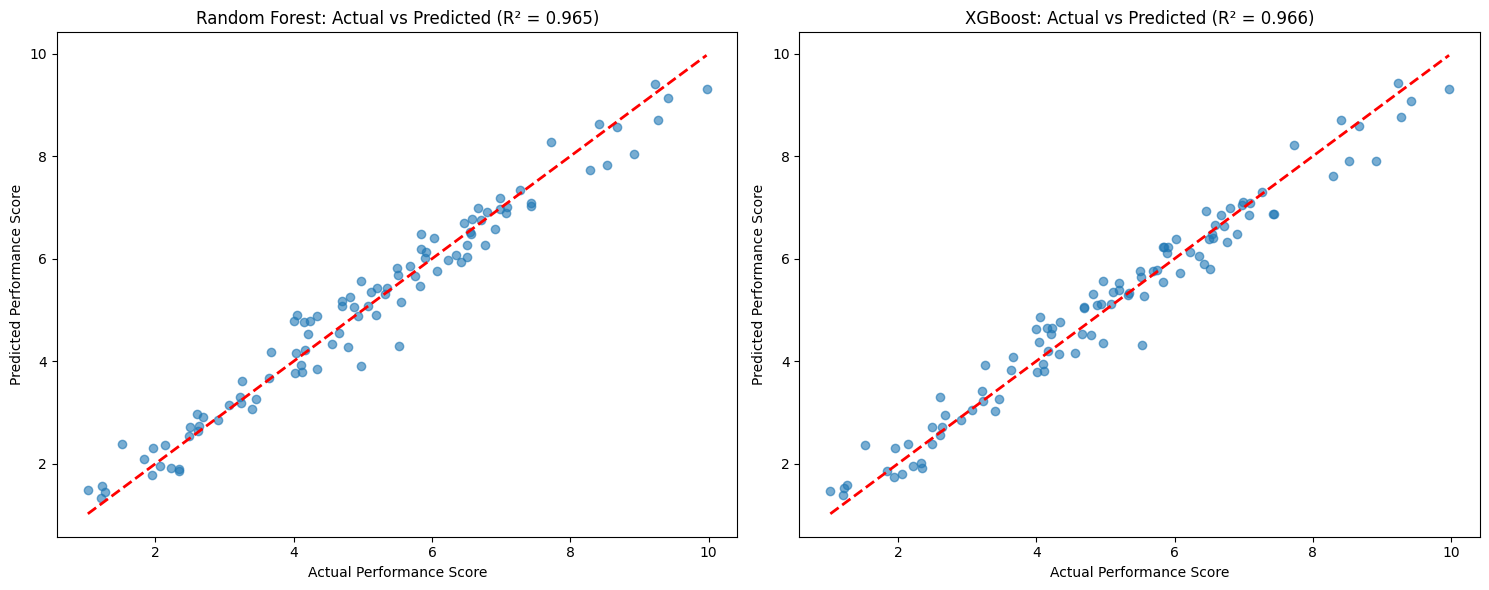


PERFORMANCE CATEGORY ANALYSIS
Actual Performance Distribution:
actual_category
Struggle    50
Good        40
Excel       10
Name: count, dtype: int64

Random Forest Predictions:
rf_predicted_category
Struggle    47
Good        43
Excel       10
Name: count, dtype: int64

XGBoost Predictions:
xgb_predicted_category
Struggle    45
Good        45
Excel       10
Name: count, dtype: int64

SAMPLE PREDICTIONS
     task_completion_time  feedback_rating  attendance_rate  actual_score  \
361                 9.146            2.813            0.684         4.019   
73                 10.524            3.488            0.607         4.103   
374                 4.570            1.102            0.699         5.500   
155                 5.936            1.510            0.901         4.819   
104                11.261            1.483            0.998         1.212   
394                 6.726            3.672            0.735         6.549   
377                 4.186            3.636           

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)
n_interns = 500

# Creating synthetic dataset
data = {
    'intern_id': [f'INTERN_{i:03d}' for i in range(1, n_interns + 1)],
    'task_completion_time': np.random.uniform(4, 12, n_interns),  # 4-12 hours
    'feedback_rating': np.random.uniform(1, 5, n_interns),        # 1-5 scale
    'attendance_rate': np.random.uniform(0.6, 1.0, n_interns),   # 60-100%
    'performance_noise': np.random.normal(0, 0.1, n_interns)     # Random noise
}

df = pd.DataFrame(data)


print("Performance Noise Statistics:")
print(df['performance_noise'].describe())
print(f"\nPerformance Noise Range: {df['performance_noise'].min():.4f} to {df['performance_noise'].max():.4f}")


# Lower completion time + higher feedback + higher attendance = better performance
df['performance_score'] = (
    (12 - df['task_completion_time']) * 0.3 +  # (faster = better)
    df['feedback_rating'] * 0.4 +              # Higher feedback = better
    df['attendance_rate'] * 0.3 +              # Higher attendance = better
    df['performance_noise']                     # Add some random variation
)

# Normalization
min_score = df['performance_score'].min()
max_score = df['performance_score'].max()
df['performance_score'] = 10 * (df['performance_score'] - min_score) / (max_score - min_score)

print("\nDataset Overview:")
print(df.head())
print(f"\nDataset Shape: {df.shape}")
print("\nTarget Variable (Performance Score) Statistics:")
print(df['performance_score'].describe())

# Data visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of features
axes[0, 0].hist(df['task_completion_time'], bins=30, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Task Completion Time Distribution')
axes[0, 0].set_xlabel('Hours')

axes[0, 1].hist(df['feedback_rating'], bins=30, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Feedback Rating Distribution')
axes[0, 1].set_xlabel('Rating (1-5)')

axes[1, 0].hist(df['attendance_rate'], bins=30, alpha=0.7, color='salmon')
axes[1, 0].set_title('Attendance Rate Distribution')
axes[1, 0].set_xlabel('Attendance Rate (0-1)')

axes[1, 1].hist(df['performance_score'], bins=30, alpha=0.7, color='gold')
axes[1, 1].set_title('Performance Score Distribution')
axes[1, 1].set_xlabel('Performance Score (0-10)')

plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = df[['task_completion_time', 'feedback_rating', 'attendance_rate', 'performance_score']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Feature Correlation Matrix')
plt.show()

# Prepare features and target
features = ['task_completion_time', 'feedback_rating', 'attendance_rate']
X = df[features]
y = df['performance_score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Model 1: Random Forest Regressor
print("\n" + "="*50)
print("RANDOM FOREST MODEL")
print("="*50)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)


rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)


rf_train_mse = mean_squared_error(y_train, rf_train_pred)
rf_test_mse = mean_squared_error(y_test, rf_test_pred)
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

print(f"Training MSE: {rf_train_mse:.4f}")
print(f"Test MSE: {rf_test_mse:.4f}")
print(f"Training MAE: {rf_train_mae:.4f}")
print(f"Test MAE: {rf_test_mae:.4f}")
print(f"Training R²: {rf_train_r2:.4f}")
print(f"Test R²: {rf_test_r2:.4f}")

# Feature importance
rf_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(rf_importance)

# Model 2: XGBoost Regressor
print("\n" + "="*50)
print("XGBOOST MODEL")
print("="*50)

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1)
xgb_model.fit(X_train_scaled, y_train)

xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_test_pred = xgb_model.predict(X_test_scaled)


xgb_train_mse = mean_squared_error(y_train, xgb_train_pred)
xgb_test_mse = mean_squared_error(y_test, xgb_test_pred)
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)

print(f"Training MSE: {xgb_train_mse:.4f}")
print(f"Test MSE: {xgb_test_mse:.4f}")
print(f"Training MAE: {xgb_train_mae:.4f}")
print(f"Test MAE: {xgb_test_mae:.4f}")
print(f"Training R²: {xgb_train_r2:.4f}")
print(f"Test R²: {xgb_test_r2:.4f}")


print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Test MSE': [rf_test_mse, xgb_test_mse],
    'Test MAE': [rf_test_mae, xgb_test_mae],
    'Test R²': [rf_test_r2, xgb_test_r2]
})

print(comparison)

# Prediction visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest predictions vs actual
axes[0].scatter(y_test, rf_test_pred, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Performance Score')
axes[0].set_ylabel('Predicted Performance Score')
axes[0].set_title(f'Random Forest: Actual vs Predicted (R² = {rf_test_r2:.3f})')

# XGBoost predictions vs actual
axes[1].scatter(y_test, xgb_test_pred, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Performance Score')
axes[1].set_ylabel('Predicted Performance Score')
axes[1].set_title(f'XGBoost: Actual vs Predicted (R² = {xgb_test_r2:.3f})')

plt.tight_layout()
plt.show()

# Classify interns as Excel/Good/Struggle based on performance score
def classify_performance(score):
    if score >= 7.5:
        return 'Excel'
    elif score >= 5.0:
        return 'Good'
    else:
        return 'Struggle'

# Add classifications to test set
test_results = X_test.copy()
test_results['actual_score'] = y_test
test_results['rf_predicted_score'] = rf_test_pred
test_results['xgb_predicted_score'] = xgb_test_pred
test_results['actual_category'] = test_results['actual_score'].apply(classify_performance)
test_results['rf_predicted_category'] = test_results['rf_predicted_score'].apply(classify_performance)
test_results['xgb_predicted_category'] = test_results['xgb_predicted_score'].apply(classify_performance)


print("\n" + "="*50)
print("PERFORMANCE CATEGORY ANALYSIS")
print("="*50)

print("Actual Performance Distribution:")
print(test_results['actual_category'].value_counts())

print("\nRandom Forest Predictions:")
print(test_results['rf_predicted_category'].value_counts())

print("\nXGBoost Predictions:")
print(test_results['xgb_predicted_category'].value_counts())


print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)

sample_results = test_results.head(10)[['task_completion_time', 'feedback_rating', 'attendance_rate',
                                       'actual_score', 'rf_predicted_score', 'xgb_predicted_score',
                                       'actual_category', 'rf_predicted_category', 'xgb_predicted_category']]

print(sample_results.round(3))

print("\n" + "="*50)
print("RECOMMENDATIONS")
print("="*50)


INTERN FEEDBACK SENTIMENT ANALYSIS

STEP 1: Creating Sample Feedback Data
----------------------------------------
Created 200 feedback samples

Sample feedback:
- I really appreciated the learning opportunities and found it amazing.
- The learning opportunities was acceptable but could be better.
- The work environment was disappointing and affected my experience.
- The feedback system was okay but has room for improvement.
- The projects exceeded my expectations and was great.


STEP 2: Text Preprocessing
----------------------------------------
Text preprocessing completed!

Example:
Original: I really appreciated the learning opportunities and found it amazing.
Cleaned:  i really appreciated the learning opportunities and found it amazing


STEP 3: Automatic Sentiment Labeling
----------------------------------------
Sentiment Distribution:
sentiment
positive    145
negative     50
neutral       5
Name: count, dtype: int64


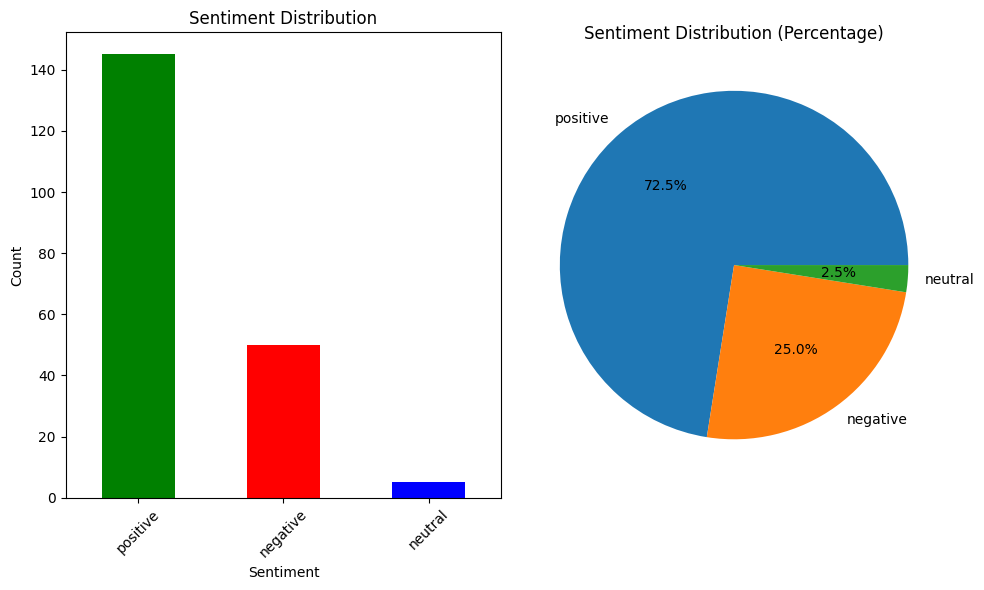



STEP 4: Preparing Data for Machine Learning
----------------------------------------
Converting text to numerical features using TF-IDF...
Text converted to 200 samples with 210 features
Label encoding: {'negative': 0, 'neutral': 1, 'positive': 2}


STEP 5: Splitting Data
----------------------------------------
Training samples: 160
Testing samples: 40


STEP 6: Training Logistic Regression Model
----------------------------------------
Model Accuracy: 97.50%


STEP 7: Model Performance Evaluation
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        10
     neutral       0.00      0.00      0.00         1
    positive       0.97      1.00      0.98        29

    accuracy                           0.97        40
   macro avg       0.66      0.67      0.66        40
weighted avg       0.95      0.97      0.96        40



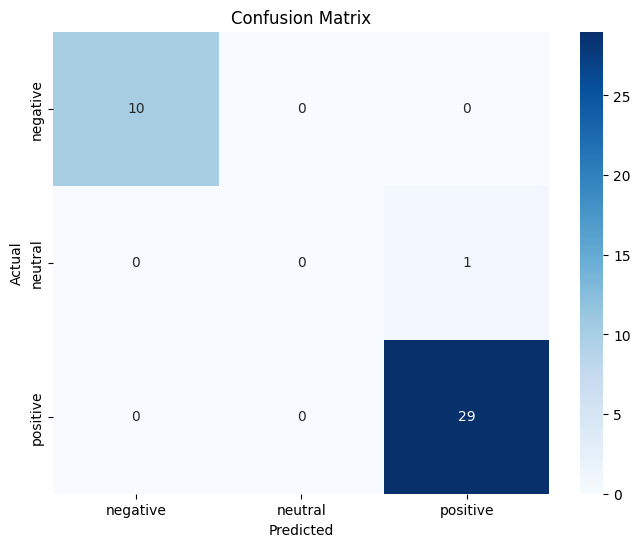



STEP 8: Identifying Key Words for Each Sentiment
----------------------------------------
Top words for each sentiment:

NEGATIVE sentiment keywords:
  - frustrating: 1.672
  - disappointed: 1.256
  - terrible: 1.154
  - disappointing: 0.708
  - needs improvement: 0.561
  - needs: 0.561
  - poor: 0.561
  - terrible needs: 0.475
  - opportunities terrible: 0.462
  - awful: 0.442

NEUTRAL sentiment keywords:
  - inadequate: 1.073
  - inadequate needs: 0.725
  - inadequate affected: 0.668
  - environment inadequate: 0.585
  - projects inadequate: 0.432
  - experience: 0.408
  - affected experience: 0.408
  - affected: 0.408
  - collaboration inadequate: 0.394
  - needs: 0.367

POSITIVE sentiment keywords:
  - special: 0.674
  - average: 0.674
  - average special: 0.674
  - acceptable better: 0.570
  - better: 0.570
  - acceptable: 0.570
  - really: 0.522
  - really appreciated: 0.522
  - appreciated: 0.522
  - room improvement: 0.495


STEP 9: Analyzing Feedback by Categories
----------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("INTERN FEEDBACK SENTIMENT ANALYSIS")
print("="*60)


print("\nSTEP 1: Creating Sample Feedback Data")
print("-" * 40)

feedback_data = {
    'intern_id': [f'INTERN_{i:03d}' for i in range(1, 201)],
    'feedback_text': [
        # Positive feedback examples
        "Great mentorship program! I learned so much about web development.",
        "The training sessions were very helpful and well-structured.",
        "I loved working on real projects and getting hands-on experience.",
        "My supervisor was supportive and gave excellent guidance.",
        "The work environment is collaborative and friendly.",
        "Amazing opportunity to work with cutting-edge technology.",
        "I feel valued and my contributions are recognized.",
        "The team is very welcoming and inclusive.",
        "Great learning curve and professional development.",
        "I enjoyed the flexible working hours and remote options.",

        # Negative feedback examples
        "The workload was overwhelming and stressful.",
        "Lack of proper guidance from supervisors.",
        "The office environment is too noisy and distracting.",
        "Not enough learning opportunities provided.",
        "Poor communication between team members.",
        "The internship didn't meet my expectations.",
        "I felt isolated and didn't get enough support.",
        "The tasks were repetitive and boring.",
        "No clear career progression path discussed.",
        "The feedback process was inconsistent.",

        # Neutral feedback examples
        "The internship was okay, average experience overall.",
        "Some aspects were good, others could be improved.",
        "It was a decent learning experience.",
        "The program has both strengths and weaknesses.",
        "Mixed feelings about the overall experience.",
    ] * 8
}


positive_templates = [
    "I really appreciated the {aspect} and found it {positive_adj}.",
    "The {aspect} was {positive_adj} and helped me grow professionally.",
    "I'm grateful for the {aspect} which was truly {positive_adj}.",
    "The {aspect} exceeded my expectations and was {positive_adj}.",
]

negative_templates = [
    "The {aspect} was {negative_adj} and needs improvement.",
    "I found the {aspect} to be {negative_adj} and frustrating.",
    "The {aspect} was {negative_adj} and affected my experience.",
    "I was disappointed with the {aspect} as it was {negative_adj}.",
]

neutral_templates = [
    "The {aspect} was acceptable but could be better.",
    "The {aspect} was average, nothing special.",
    "The {aspect} was okay but has room for improvement.",
]

aspects = ['training', 'mentorship', 'work environment', 'projects', 'team collaboration',
           'feedback system', 'learning opportunities', 'work-life balance']
positive_adj = ['excellent', 'outstanding', 'amazing', 'fantastic', 'wonderful', 'great']
negative_adj = ['poor', 'terrible', 'disappointing', 'inadequate', 'frustrating', 'awful']


np.random.seed(42)
extended_feedback = []
extended_ids = []

for i in range(200):
    intern_id = f'INTERN_{i+1:03d}'

    # 40% positive, 30% negative, 30% neutral
    sentiment_type = np.random.choice(['positive', 'negative', 'neutral'],
                                    p=[0.4, 0.3, 0.3])

    if sentiment_type == 'positive':
        template = np.random.choice(positive_templates)
        aspect = np.random.choice(aspects)
        adj = np.random.choice(positive_adj)
        feedback = template.format(aspect=aspect, positive_adj=adj)
    elif sentiment_type == 'negative':
        template = np.random.choice(negative_templates)
        aspect = np.random.choice(aspects)
        adj = np.random.choice(negative_adj)
        feedback = template.format(aspect=aspect, negative_adj=adj)
    else:
        template = np.random.choice(neutral_templates)
        aspect = np.random.choice(aspects)
        feedback = template.format(aspect=aspect)

    extended_feedback.append(feedback)
    extended_ids.append(intern_id)


df = pd.DataFrame({
    'intern_id': extended_ids,
    'feedback_text': extended_feedback
})

print(f"Created {len(df)} feedback samples")
print("\nSample feedback:")
for i in range(5):
    print(f"- {df.iloc[i]['feedback_text']}")


print("\n\nSTEP 2: Text Preprocessing")
print("-" * 40)

def clean_text(text):
    """Simple text cleaning function"""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

df['cleaned_text'] = df['feedback_text'].apply(clean_text)

print("Text preprocessing completed!")
print("\nExample:")
print(f"Original: {df.iloc[0]['feedback_text']}")
print(f"Cleaned:  {df.iloc[0]['cleaned_text']}")


print("\n\nSTEP 3: Automatic Sentiment Labeling")
print("-" * 40)

def get_sentiment_label(text):
    """Get sentiment label using TextBlob"""
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['feedback_text'].apply(get_sentiment_label)

# Show sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution (Percentage)')

plt.tight_layout()
plt.show()

# STEP 4: PREPARE DATA FOR MACHINE LEARNING
# =========================================
print("\n\nSTEP 4: Preparing Data for Machine Learning")
print("-" * 40)

# Convert text to numerical features using TF-IDF
print("Converting text to numerical features using TF-IDF...")

# TF-IDF Vectorizer (converts text to numbers)
tfidf = TfidfVectorizer(
    max_features=1000,  # Use top 1000 words
    stop_words='english',  # Remove common words like 'the', 'and'
    ngram_range=(1, 2)  # Use single words and word pairs
)

# Fit and transform the text data
X = tfidf.fit_transform(df['cleaned_text'])
y = df['sentiment']

print(f"Text converted to {X.shape[0]} samples with {X.shape[1]} features")

# Encode labels to numbers (positive=2, neutral=1, negative=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Label encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# STEP 5: SPLIT DATA INTO TRAINING AND TESTING
# ============================================
print("\n\nSTEP 5: Splitting Data")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# STEP 6: TRAIN LOGISTIC REGRESSION MODEL
# =======================================
print("\n\nSTEP 6: Training Logistic Regression Model")
print("-" * 40)

# Create and train the model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# STEP 7: EVALUATE MODEL PERFORMANCE
# =================================
print("\n\nSTEP 7: Model Performance Evaluation")
print("-" * 40)

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# STEP 8: IDENTIFY KEY WORDS FOR EACH SENTIMENT
# =============================================
print("\n\nSTEP 8: Identifying Key Words for Each Sentiment")
print("-" * 40)

# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

# Get the most important words for each sentiment
def get_top_words(sentiment_class, n_words=10):
    """Get top words that indicate a specific sentiment"""
    coef = model.coef_[sentiment_class]
    top_indices = coef.argsort()[-n_words:][::-1]
    return [(feature_names[i], coef[i]) for i in top_indices]

print("Top words for each sentiment:")
for i, sentiment in enumerate(label_encoder.classes_):
    print(f"\n{sentiment.upper()} sentiment keywords:")
    top_words = get_top_words(i, 10)
    for word, score in top_words:
        print(f"  - {word}: {score:.3f}")


print("\n\nSTEP 9: Analyzing Feedback by Categories")
print("-" * 40)

# Group feedback by sentiment and extract common themes
def extract_themes(sentiment_type):
    """Extract common themes from feedback of a specific sentiment"""
    subset = df[df['sentiment'] == sentiment_type]['feedback_text'].tolist()

    # Find common words (simple approach)
    all_words = []
    for text in subset:
        words = clean_text(text).split()
        all_words.extend(words)

    # Get most common words
    word_counts = Counter(all_words)
    common_words = [word for word, count in word_counts.most_common(10)
                   if word not in ['the', 'and', 'was', 'is', 'it', 'to', 'of', 'a', 'in', 'for']]

    return common_words[:5]

print("Common themes by sentiment:")
for sentiment in ['positive', 'negative', 'neutral']:
    themes = extract_themes(sentiment)
    print(f"\n{sentiment.upper()} feedback themes:")
    for theme in themes:
        print(f"  - {theme}")


print("\n\nSTEP 10: Recommendations for Improvement")
print("-" * 40)


negative_feedback = df[df['sentiment'] == 'negative']['feedback_text'].tolist()

print("Areas for improvement based on negative feedback:")
improvement_areas = {
    'mentorship': ['guidance', 'supervisor', 'support', 'mentor'],
    'workload': ['overwhelming', 'stressful', 'workload', 'pressure'],
    'environment': ['environment', 'noisy', 'distracting', 'office'],
    'learning': ['learning', 'opportunities', 'training', 'development'],
    'communication': ['communication', 'feedback', 'isolated', 'team']
}

for area, keywords in improvement_areas.items():
    count = 0
    for feedback in negative_feedback:
        if any(keyword in feedback.lower() for keyword in keywords):
            count += 1

    if count > 0:
        percentage = (count / len(negative_feedback)) * 100
        print(f"  - {area.title()}: {count} mentions ({percentage:.1f}% of negative feedback)")


print("\n\nSTEP 11: Function to Predict New Feedback")
print("-" * 40)

def predict_sentiment(new_feedback):
    """Predict sentiment of new feedback text"""

    cleaned = clean_text(new_feedback)


    features = tfidf.transform([cleaned])

    prediction = model.predict(features)[0]
    confidence = model.predict_proba(features)[0].max()

    sentiment_label = label_encoder.inverse_transform([prediction])[0]

    return sentiment_label, confidence

# Test the function
print("Testing sentiment prediction on new feedback:")
test_feedback = [
    "The mentorship program was absolutely fantastic and I learned so much!",
    "The workload was too much and I didn't get enough support from my supervisor.",
    "The internship was okay, nothing special but not bad either."
]

for i, feedback in enumerate(test_feedback, 1):
    sentiment, confidence = predict_sentiment(feedback)
    print(f"\nTest {i}: {feedback}")
    print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2%})")


Learning Path Recommendation System

Creating sample data...
Created 100 interns and 21 courses

Generating learning interactions...
Generated 1085 learning interactions

Building rating matrix...
Matrix size: (100, 21)
Sparsity: 48.3%

Training recommendation model...
Model training completed

Testing recommendations...

Recommendations for Intern_1 (INT_001)
Department: Data Science, Skill: Beginner

Collaborative Filtering:
  1. JavaScript Fundamentals (Web Dev)
     Difficulty: Beginner, Duration: 22h
     Predicted Rating: 2.72
  2. Full Stack Project (Web Dev)
     Difficulty: Advanced, Duration: 40h
     Predicted Rating: 2.19
  3. Computer Vision (AI/ML)
     Difficulty: Advanced, Duration: 30h
     Predicted Rating: 1.52

Content-Based:
  1. JavaScript Fundamentals (Web Dev)
     Difficulty: Beginner, Duration: 22h
     Similarity Score: 0.75
  2. Git and Version Control (DevOps)
     Difficulty: Beginner, Duration: 15h
     Similarity Score: 0.5
  3. Mobile App Design (Mobile

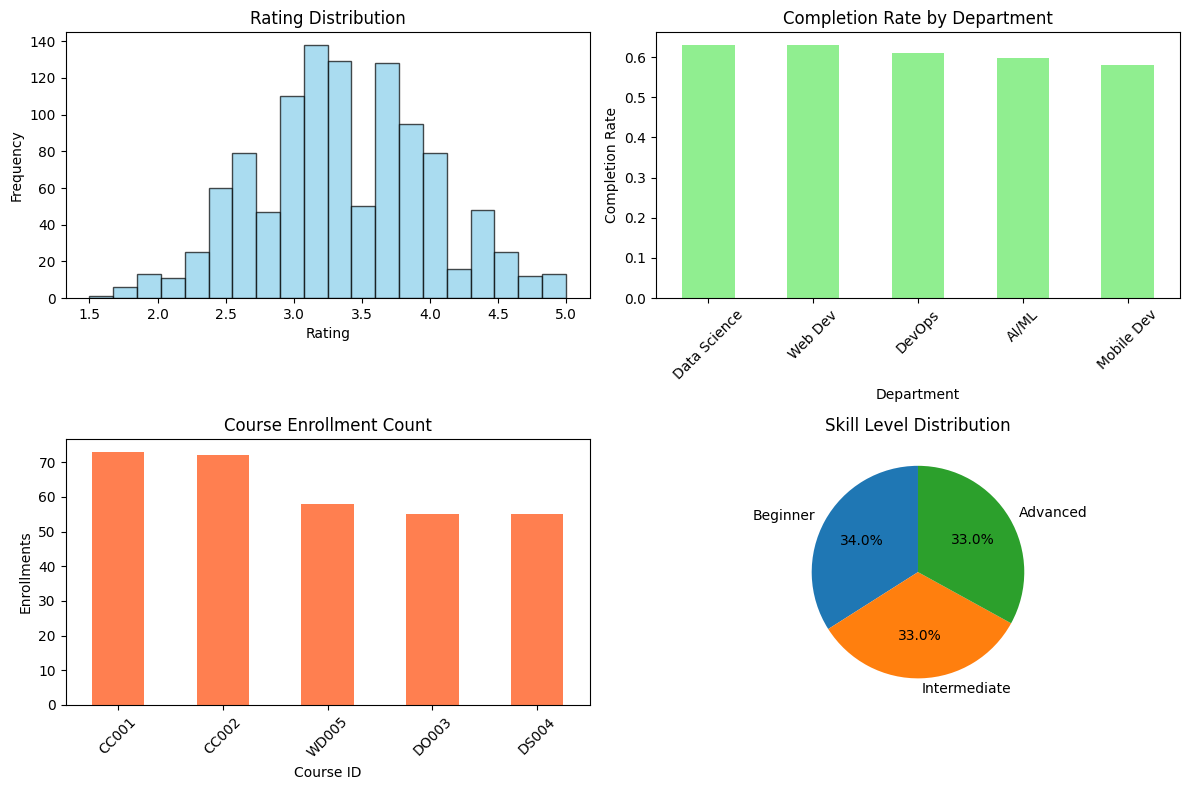


Learning Path Recommendation System Ready!
The system can now provide personalized learning recommendations for interns.


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Learning Path Recommendation System")
print("===================================")

print("\nCreating sample data...")

interns = [
    {'intern_id': f'INT_{i:03d}', 'name': f'Intern_{i}', 'department': dept, 'skill_level': level}
    for i, (dept, level) in enumerate(zip(
        ['Data Science', 'Web Dev', 'Mobile Dev', 'AI/ML', 'DevOps'] * 20,
        ['Beginner', 'Intermediate', 'Advanced'] * 33 + ['Beginner']
    ), 1)
]

courses = [
    {'course_id': 'DS001', 'title': 'Python Fundamentals', 'category': 'Data Science', 'difficulty': 'Beginner', 'duration': 20},
    {'course_id': 'DS002', 'title': 'Statistics for Data Science', 'category': 'Data Science', 'difficulty': 'Beginner', 'duration': 25},
    {'course_id': 'DS003', 'title': 'Data Visualization with Matplotlib', 'category': 'Data Science', 'difficulty': 'Intermediate', 'duration': 15},
    {'course_id': 'DS004', 'title': 'Machine Learning Basics', 'category': 'Data Science', 'difficulty': 'Intermediate', 'duration': 30},
    {'course_id': 'DS005', 'title': 'Deep Learning Fundamentals', 'category': 'Data Science', 'difficulty': 'Advanced', 'duration': 35},
    {'course_id': 'WD001', 'title': 'HTML/CSS Basics', 'category': 'Web Dev', 'difficulty': 'Beginner', 'duration': 18},
    {'course_id': 'WD002', 'title': 'JavaScript Fundamentals', 'category': 'Web Dev', 'difficulty': 'Beginner', 'duration': 22},
    {'course_id': 'WD003', 'title': 'React.js Development', 'category': 'Web Dev', 'difficulty': 'Intermediate', 'duration': 28},
    {'course_id': 'WD004', 'title': 'Node.js Backend', 'category': 'Web Dev', 'difficulty': 'Intermediate', 'duration': 25},
    {'course_id': 'WD005', 'title': 'Full Stack Project', 'category': 'Web Dev', 'difficulty': 'Advanced', 'duration': 40},
    {'course_id': 'MD001', 'title': 'Mobile App Design', 'category': 'Mobile Dev', 'difficulty': 'Beginner', 'duration': 20},
    {'course_id': 'MD002', 'title': 'React Native Basics', 'category': 'Mobile Dev', 'difficulty': 'Intermediate', 'duration': 30},
    {'course_id': 'MD003', 'title': 'iOS Development', 'category': 'Mobile Dev', 'difficulty': 'Advanced', 'duration': 35},
    {'course_id': 'AI001', 'title': 'AI Ethics and Principles', 'category': 'AI/ML', 'difficulty': 'Beginner', 'duration': 12},
    {'course_id': 'AI002', 'title': 'Natural Language Processing', 'category': 'AI/ML', 'difficulty': 'Intermediate', 'duration': 25},
    {'course_id': 'AI003', 'title': 'Computer Vision', 'category': 'AI/ML', 'difficulty': 'Advanced', 'duration': 30},
    {'course_id': 'DO001', 'title': 'Git and Version Control', 'category': 'DevOps', 'difficulty': 'Beginner', 'duration': 15},
    {'course_id': 'DO002', 'title': 'Docker Containerization', 'category': 'DevOps', 'difficulty': 'Intermediate', 'duration': 20},
    {'course_id': 'DO003', 'title': 'Kubernetes Orchestration', 'category': 'DevOps', 'difficulty': 'Advanced', 'duration': 25},
    {'course_id': 'CC001', 'title': 'Project Management', 'category': 'General', 'difficulty': 'Beginner', 'duration': 10},
    {'course_id': 'CC002', 'title': 'Communication Skills', 'category': 'General', 'difficulty': 'Beginner', 'duration': 8},
]

interns_df = pd.DataFrame(interns)
courses_df = pd.DataFrame(courses)

print(f"Created {len(interns_df)} interns and {len(courses_df)} courses")

print("\nGenerating learning interactions...")

np.random.seed(42)
interactions = []

for intern in interns:
    intern_id = intern['intern_id']
    dept = intern['department']
    skill = intern['skill_level']

    num_interactions = np.random.randint(5, 16)

    course_weights = []
    for course in courses:
        if course['category'] == dept:
            weight = 0.6
        elif course['category'] == 'General':
            weight = 0.3
        else:
            weight = 0.1
        course_weights.append(weight)

    selected_courses = np.random.choice(
        len(courses),
        size=num_interactions,
        replace=False,
        p=np.array(course_weights) / np.sum(course_weights)
    )

    for course_idx in selected_courses:
        course = courses[course_idx]

        base_rating = 3.0

        if skill == 'Beginner' and course['difficulty'] == 'Beginner':
            base_rating += 1.0
        elif skill == 'Intermediate' and course['difficulty'] == 'Intermediate':
            base_rating += 0.8
        elif skill == 'Advanced' and course['difficulty'] == 'Advanced':
            base_rating += 0.6
        elif skill == 'Advanced' and course['difficulty'] == 'Beginner':
            base_rating += 0.3

        rating = base_rating + np.random.normal(0, 0.5)
        rating = max(1.0, min(5.0, rating))

        completion_prob = (rating - 1) / 4
        completed = np.random.random() < completion_prob

        interactions.append({
            'intern_id': intern_id,
            'course_id': course['course_id'],
            'rating': round(rating, 1),
            'completed': completed,
            'progress': np.random.randint(60, 101) if completed else np.random.randint(10, 90),
            'timestamp': datetime.now() - timedelta(days=np.random.randint(1, 90))
        })

interactions_df = pd.DataFrame(interactions)
print(f"Generated {len(interactions_df)} learning interactions")

print("\nBuilding rating matrix...")

rating_matrix = interactions_df.pivot_table(
    index='intern_id',
    columns='course_id',
    values='rating',
    fill_value=0
)

print(f"Matrix size: {rating_matrix.shape}")
sparsity = (rating_matrix == 0).sum().sum() / (rating_matrix.shape[0] * rating_matrix.shape[1]) * 100
print(f"Sparsity: {sparsity:.1f}%")

print("\nTraining recommendation model...")

n_components = 10
model = NMF(n_components=n_components, init='random', random_state=42, max_iter=200)

user_features = model.fit_transform(rating_matrix)
item_features = model.components_

predicted_ratings = np.dot(user_features, item_features)
predicted_ratings_df = pd.DataFrame(
    predicted_ratings,
    index=rating_matrix.index,
    columns=rating_matrix.columns
)

print(f"Model training completed")

def get_recommendations(intern_id, n_recommendations=5):
    if intern_id not in rating_matrix.index:
        return f"Intern {intern_id} not found"

    intern_ratings = rating_matrix.loc[intern_id]
    intern_predictions = predicted_ratings_df.loc[intern_id]

    unrated_courses = intern_ratings[intern_ratings == 0].index
    recommendations = intern_predictions[unrated_courses].sort_values(ascending=False)
    top_recommendations = recommendations.head(n_recommendations)

    rec_details = []
    for course_id, predicted_rating in top_recommendations.items():
        course_info = courses_df[courses_df['course_id'] == course_id].iloc[0]
        rec_details.append({
            'course_id': course_id,
            'title': course_info['title'],
            'category': course_info['category'],
            'difficulty': course_info['difficulty'],
            'duration': course_info['duration'],
            'predicted_rating': round(predicted_rating, 2)
        })

    return rec_details

def get_content_based_recommendations(intern_id, n_recommendations=5):
    if intern_id not in rating_matrix.index:
        return f"Intern {intern_id} not found"

    intern_ratings = rating_matrix.loc[intern_id]
    liked_courses = intern_ratings[intern_ratings >= 4.0].index

    if len(liked_courses) == 0:
        return "No highly rated courses found"

    course_features = pd.get_dummies(courses_df[['category', 'difficulty']])
    course_features.index = courses_df['course_id']

    similarity_matrix = cosine_similarity(course_features)
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=course_features.index,
        columns=course_features.index
    )

    similar_courses = {}
    for course_id in liked_courses:
        if course_id in similarity_df.index:
            similar = similarity_df[course_id].sort_values(ascending=False)
            unrated_similar = similar[~similar.index.isin(intern_ratings[intern_ratings > 0].index)]
            similar_courses[course_id] = unrated_similar.head(3)

    all_recommendations = {}
    for course_id, similar in similar_courses.items():
        for sim_course, sim_score in similar.items():
            if sim_course not in all_recommendations:
                all_recommendations[sim_course] = []
            all_recommendations[sim_course].append(sim_score)

    final_recommendations = {
        course: np.mean(scores)
        for course, scores in all_recommendations.items()
    }

    sorted_recommendations = sorted(
        final_recommendations.items(),
        key=lambda x: x[1],
        reverse=True
    )[:n_recommendations]

    rec_details = []
    for course_id, similarity_score in sorted_recommendations:
        course_info = courses_df[courses_df['course_id'] == course_id].iloc[0]
        rec_details.append({
            'course_id': course_id,
            'title': course_info['title'],
            'category': course_info['category'],
            'difficulty': course_info['difficulty'],
            'duration': course_info['duration'],
            'similarity_score': round(similarity_score, 3)
        })

    return rec_details

print("\nTesting recommendations...")

sample_interns = interns_df['intern_id'].head(3).tolist()

for intern_id in sample_interns:
    intern_info = interns_df[interns_df['intern_id'] == intern_id].iloc[0]

    print(f"\nRecommendations for {intern_info['name']} ({intern_id})")
    print(f"Department: {intern_info['department']}, Skill: {intern_info['skill_level']}")

    print("\nCollaborative Filtering:")
    cf_recs = get_recommendations(intern_id, 3)
    for i, rec in enumerate(cf_recs, 1):
        print(f"  {i}. {rec['title']} ({rec['category']})")
        print(f"     Difficulty: {rec['difficulty']}, Duration: {rec['duration']}h")
        print(f"     Predicted Rating: {rec['predicted_rating']}")

    print("\nContent-Based:")
    cb_recs = get_content_based_recommendations(intern_id, 3)
    if isinstance(cb_recs, str):
        print(f"  {cb_recs}")
    else:
        for i, rec in enumerate(cb_recs, 1):
            print(f"  {i}. {rec['title']} ({rec['category']})")
            print(f"     Difficulty: {rec['difficulty']}, Duration: {rec['duration']}h")
            print(f"     Similarity Score: {rec['similarity_score']}")

print("\nSystem Statistics")
print("=================")

print("\nRating Distribution:")
rating_dist = interactions_df['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    print(f"  {rating} stars: {count} ratings ({count/len(interactions_df)*100:.1f}%)")

print("\nCompletion Rates by Department:")
completion_by_dept = interactions_df.merge(
    interns_df[['intern_id', 'department']],
    on='intern_id'
).groupby('department')['completed'].mean().sort_values(ascending=False)

for dept, rate in completion_by_dept.items():
    print(f"  {dept}: {rate:.1%}")

print("\nMost Popular Courses:")
popular_courses = interactions_df.groupby('course_id').agg({
    'rating': 'mean',
    'completed': 'mean',
    'intern_id': 'count'
}).round(2).sort_values('intern_id', ascending=False).head(5)

popular_courses.columns = ['Avg_Rating', 'Completion_Rate', 'Enrollments']
for course_id, stats in popular_courses.iterrows():
    course_title = courses_df[courses_df['course_id'] == course_id]['title'].iloc[0]
    print(f"  {course_title}")
    print(f"    Enrollments: {stats['Enrollments']}, Rating: {stats['Avg_Rating']}, Completion: {stats['Completion_Rate']:.1%}")

print("\nRecommendation Functions Available:")
print("  get_recommendations(intern_id, n_recommendations=5)")
print("  get_content_based_recommendations(intern_id, n_recommendations=5)")
print(f"\nSample intern IDs: {', '.join(interns_df['intern_id'].head(10).tolist())}")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(interactions_df['rating'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
completion_by_dept.plot(kind='bar', color='lightgreen')
plt.title('Completion Rate by Department')
plt.xlabel('Department')
plt.ylabel('Completion Rate')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
popular_courses['Enrollments'].plot(kind='bar', color='coral')
plt.title('Course Enrollment Count')
plt.xlabel('Course ID')
plt.ylabel('Enrollments')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
skill_dist = interns_df['skill_level'].value_counts()
plt.pie(skill_dist.values, labels=skill_dist.index, autopct='%1.1f%%', startangle=90)
plt.title('Skill Level Distribution')

plt.tight_layout()
plt.show()

print("\nLearning Path Recommendation System Ready!")
print("The system can now provide personalized learning recommendations for interns.")